In [225]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('ggplot')
sns.set_context("paper")
%matplotlib inline

In [163]:
df=pd.read_csv('../../data/processed/merged_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65551 entries, 0 to 65550
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SalePrice            65551 non-null  int64  
 1   Township             65551 non-null  int64  
 2   SqFtLot              65551 non-null  int64  
 3   MtRainier            65551 non-null  int64  
 4   Olympics             65551 non-null  int64  
 5   Cascades             65551 non-null  int64  
 6   Territorial          65551 non-null  int64  
 7   SeattleSkyline       65551 non-null  int64  
 8   PugetSound           65551 non-null  int64  
 9   LakeWashington       65551 non-null  int64  
 10  LakeSammamish        65551 non-null  int64  
 11  SmallLakeRiverCreek  65551 non-null  int64  
 12  OtherView            65551 non-null  int64  
 13  WfntFootage          65551 non-null  int64  
 14  BldgGrade            65551 non-null  int64  
 15  SqFtUnfinFull        65551 non-null 

In [164]:
df.head()

,SalePrice,Township,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,BldgGrade,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,ViewUtilization,Bedrooms,YrBuilt,YrRenovated,PcntComplete,Condition,AddnlCost,SaleWarning,TotBathrooms,TotFireplace
0,800000,26,10560,0,2,0,2,0,2,0,0,0,0,0,9,0,0,4200,2410,1850,8,560,0,220,0,390,7,3,N,3,1968,0,0,4,0,15 51,3.25,2
1,730000,26,9853,0,0,0,0,0,0,0,0,0,0,0,7,0,0,2410,1200,1200,6,0,500,110,0,0,5,2,NaN,5,1969,0,0,3,0,,3.00,2
2,875000,25,3600,0,0,0,0,0,0,0,0,0,0,0,8,0,0,1890,750,0,0,220,0,190,0,0,5,1,NaN,4,1919,0,0,3,0,,1.00,1
3,249950,26,7750,0,0,0,0,0,0,0,0,0,0,0,8,0,0,3340,2180,960,8,750,0,250,0,0,5,2,NaN,5,2019,0,58,3,5000,10,3.25,2
4,205000,26,7750,0,0,0,0,0,0,0,0,0,0,0,8,0,0,3340,2180,960,8,750,0,250,0,0,5,2,NaN,5,2019,0,58,3,5000,15,3.25,2


In [165]:
# Checking for correlation.

In [166]:
corr = np.abs(df.corr())

In [167]:
corr = corr.sort_values('SalePrice', ascending=False)

In [168]:
# Including mask for readibility.

In [169]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

In [170]:
# Creating correlogram to display correlation data.

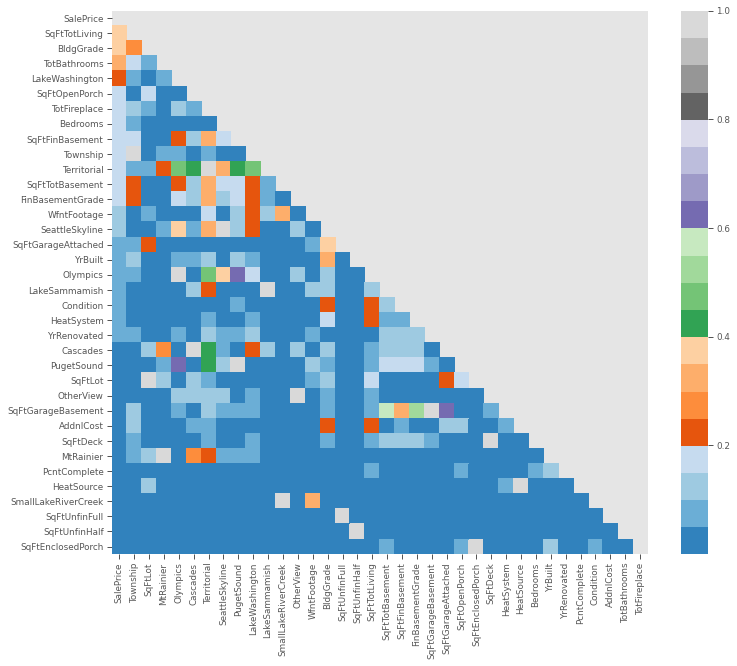

In [223]:
fig1, ax1 = plt.subplots(figsize=(12,10))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="tab20c");

### Model 1 - Correlated Variables

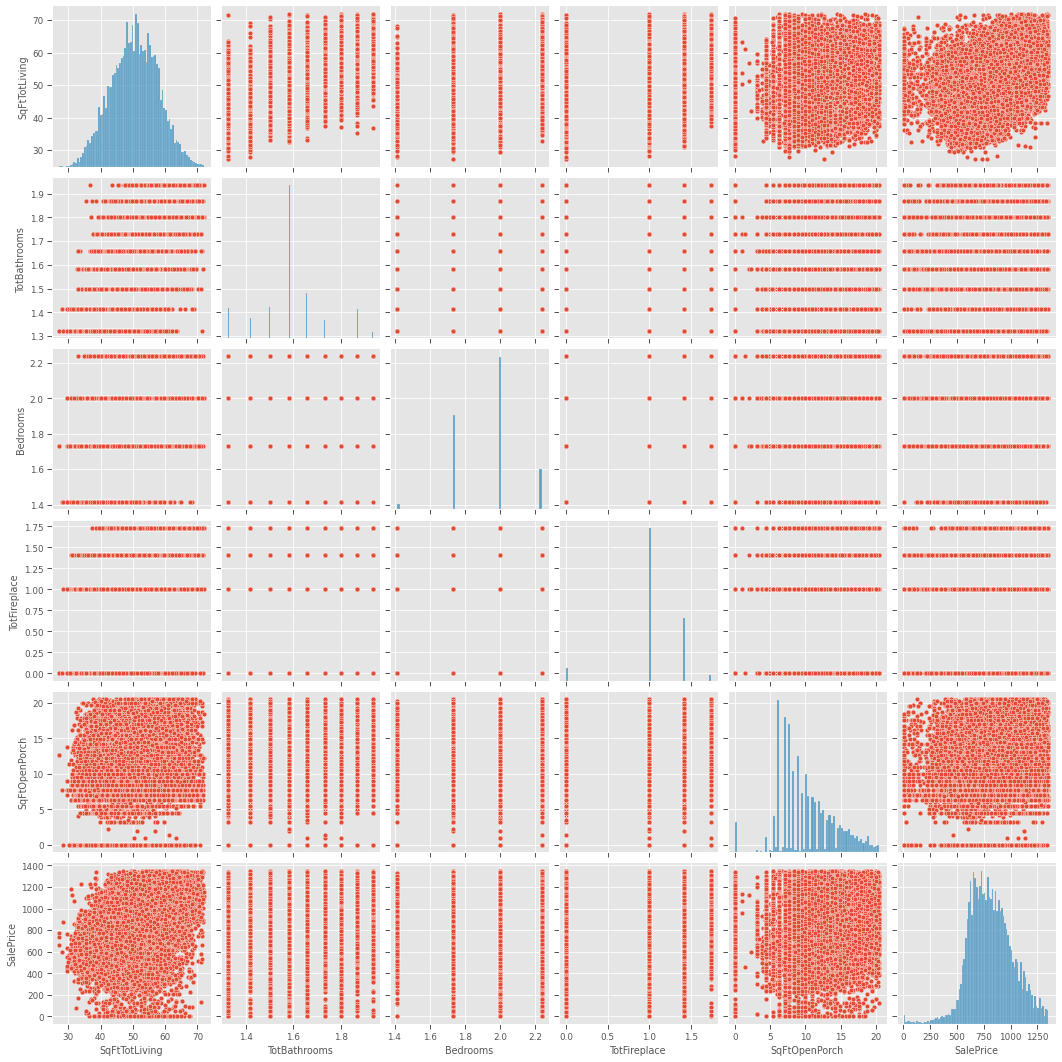

In [227]:
cor_cols = ['SqFtTotLiving', 'TotBathrooms','Bedrooms', 'TotFireplace', 'SqFtOpenPorch', 'SalePrice']
cor_cols_df = df[cor_cols]
sns.pairplot(cor_cols_df)
plt.show();

The Pairplot visualizes the correlation between the selected variables. While none of variables appear to have a strong linear relationship, SqFtTotLiving had the highest correlation and will be used for further analysis.

In [173]:
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()
fsm_df.dropna(inplace=True)

In [174]:
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data = fsm_df)
fsm_results = fsm.fit()

In [175]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                 1.178e+04
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:47:50   Log-Likelihood:            -9.9856e+05
No. Observations:               65551   AIC:                         1.997e+06
Df Residuals:                   65549   BIC:                         1.997e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.181e+05   1.11e+04    -19.705      0.000    -2.4e+05   -1.96e+05
SqFtTotLiving   406.2319      3.742    108.550      0.000     398.897     413.567
==============================================================================
Omnibus:                   107659.227   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         96774287.230
Skew:                          10.995   Prob(JB):                         0.00
Kurtosis:                     189.944   Cond. No.                     8.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 1 Evaluation

R2 and Adj R2 are both 0.152 so only about 15% of the variability in SalePrice (dependent variable) can be  explained by SqFtTotLiving (independent variable) using this model.

The Prob(F-statistic) which estimates the likelylood that this model resulting the way it does by chance is 0.

##### Linearity

In [176]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fsm_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:",rainbow_p_value)

Rainbow statistic: 1.0251003903836522
Rainbow p-value: 0.012417471243296625


I used the linear_rainbox(model_results) from Stats models. Its null-hypothesis is that the model shows linearity. The alternate hypothesis is that it does not. The p-value is low meaning that we have sufficient evidence to reject the null-hypothesis. The model violates the assumption of linearity.

##### Normality

For this I used the Jarque-Bera test and Jarque-Bera (JB) p-value. The null hypothesis is that the residuals are normally distributed.  The alternative is that they are not. The p-value is 0 meaning that normality is violated. 

##### Homoscadasticity

Homoscadasticity can be visualized using the predicted SalePrice vs the residuals.

In [177]:
y = fsm_df['SalePrice']
y_hat = fsm_results.predict()

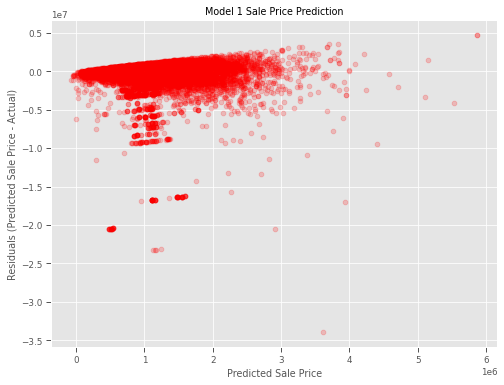

In [232]:
fig2, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title("Model 1 Sale Price Prediction")
ax1.set(xlabel="Predicted Sale Price", ylabel="Residuals (Predicted Sale Price - Actual)")
ax1.scatter(x=y_hat, y=y_hat-y, color='red', alpha=0.2);

In [179]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, fsm_df[['SalePrice']])

print("Lagrange Multiplier p-value:", lm_p_value)
print("F-Statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-Statistic p-value: 0.0


The null hypothesis is that the data is homoscadatic. Based on the graphical representation and het_breuschpagan test, we have sufficient evidence to reject the null hypothesis. There appears to be underestimation for SalePrice. Further investigation is needed for this dependent variable. 

### Model 2 - Correlated Variables

In [180]:
## Further investigating data for outliers and reasonability.

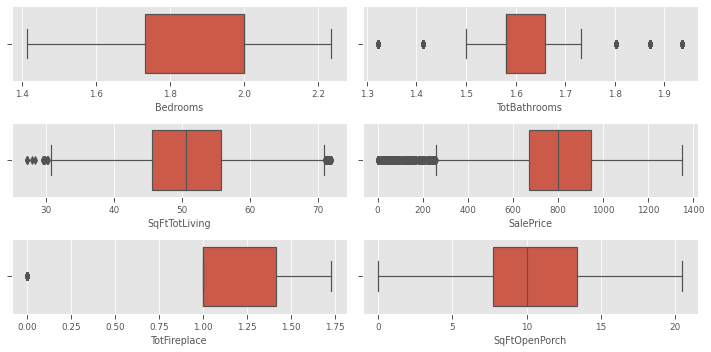

In [230]:
fig3, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(10,5))

sns.boxplot(x=df.Bedrooms, ax=ax1);
sns.boxplot(x=df.TotBathrooms, ax=ax2);
sns.boxplot(x=df.SqFtTotLiving, ax=ax3);
sns.boxplot(x=df.SalePrice, ax=ax4);
sns.boxplot(x=df.TotFireplace, ax=ax5);
sns.boxplot(x=df.SqFtOpenPorch, ax=ax6);

plt.tight_layout()

Model 1 calculated that a skew of as 10.995, a number that should be closer to zero for normally distributed data. The boxplots show that the data is heavily skewed to the right and is heavliy impacted by outliers. Outliers will be removed. Then, a log transformation will be used to normalize the data for use in model 2.

In [182]:
df = df[(df.TotBathrooms >=1)] 
len(df) #65482

65482

In [183]:
df = df[(df.Bedrooms >=1)] 
len(df) #65462

65462

In [184]:
non_normal = ['SalePrice','SqFtTotLiving', 'TotBathrooms','Bedrooms','SqFtOpenPorch', 'TotFireplace']

Q1 = df[non_normal].quantile(0.25)
Q3 = df[non_normal].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[non_normal] < (Q1 - 1.5 * IQR)) |
          (df[non_normal] > (Q3 + 1.5 * IQR))).any(axis=1)]
len(df) #51160

51160

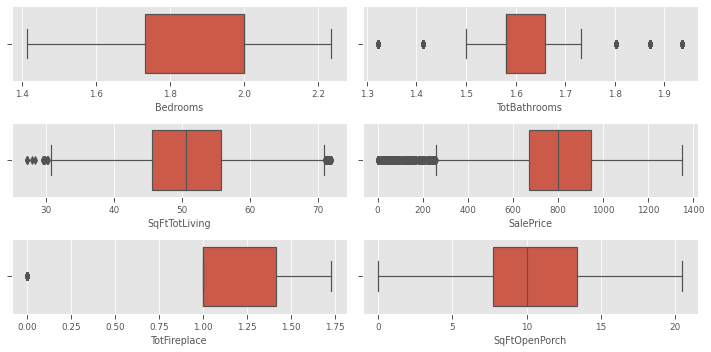

In [229]:
fig4, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(10,5))

sns.boxplot(x=df.Bedrooms, ax=ax1);
sns.boxplot(x=df.TotBathrooms, ax=ax2);
sns.boxplot(x=df.SqFtTotLiving, ax=ax3);
sns.boxplot(x=df.SalePrice, ax=ax4);
sns.boxplot(x=df.TotFireplace, ax=ax5);
sns.boxplot(x=df.SqFtOpenPorch, ax=ax6);

plt.tight_layout()

In [186]:
import numpy as np
non_normal2 = ['SalePrice','SqFtTotLiving', 'TotBathrooms','Bedrooms','SqFtOpenPorch', 'TotFireplace']

for feat in non_normal:
    df[feat] = df[feat].map(lambda x: np.sqrt(x))

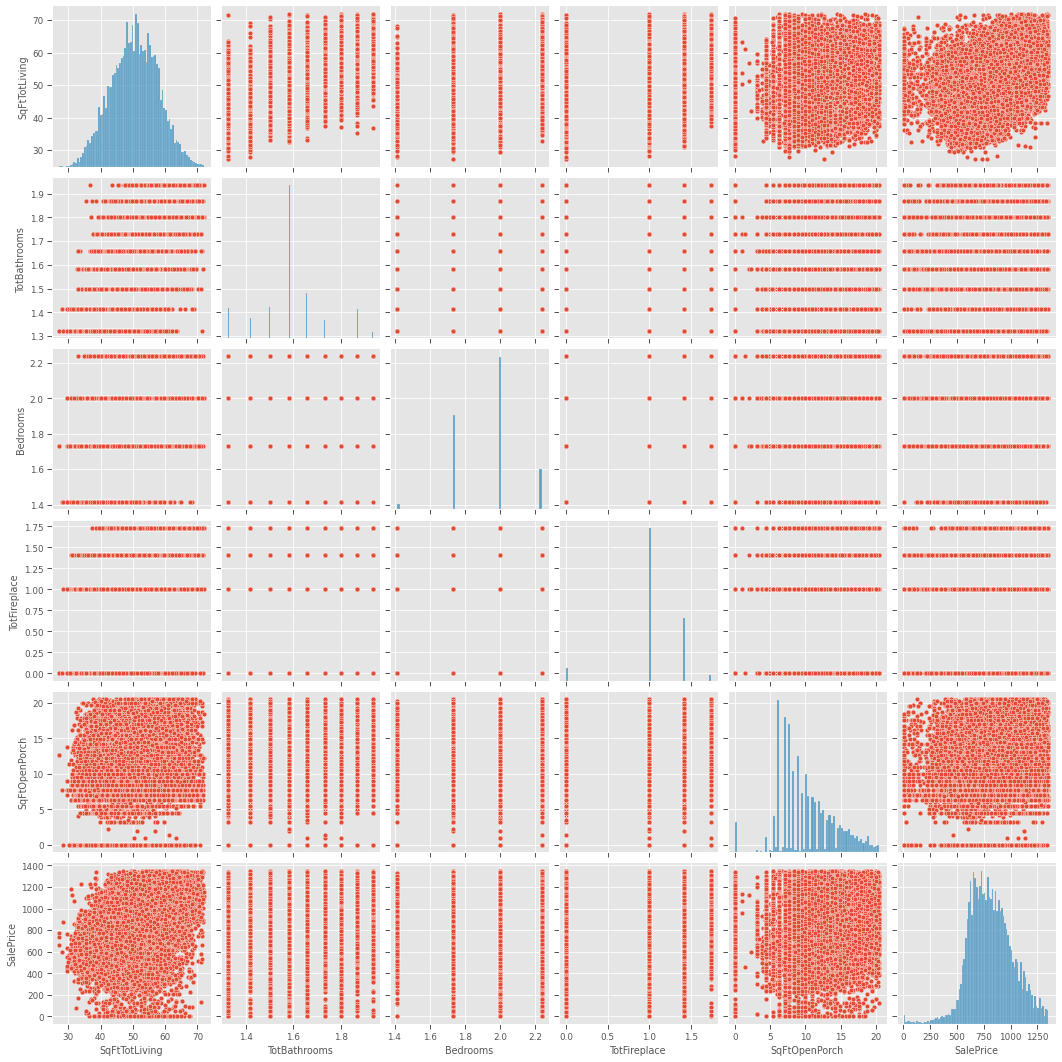

In [231]:
cor_cols2 = ['SqFtTotLiving', 'TotBathrooms','Bedrooms', 'TotFireplace', 'SqFtOpenPorch','SalePrice']
cor_cols_df2 = df[cor_cols2]
sns.pairplot(cor_cols_df2)
plt.show()

The Pairplot visualizes the correlation between the selected variables. While none of variables appear to have a strong linear relationship, SqFtTotLiving had the highest correlation and will be used for further analysis.

In [188]:
ssm_df = df[["SalePrice", "SqFtTotLiving", "TotBathrooms"]].copy()
ssm_df.dropna(inplace=True)

In [189]:
ssm = ols(formula="SalePrice ~ SqFtTotLiving + TotBathrooms", data = ssm_df)
ssm_results = ssm.fit()

In [190]:
ssm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     8283.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:48:00   Log-Likelihood:            -3.3769e+05
No. Observations:               51160   AIC:                         6.754e+05
Df Residuals:                   51157   BIC:                         6.754e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       104.8875      8.693     12.066      0.000      87.850     121.925
SqFtTotLiving    14.1705      0.146     97.140      0.000      13.885      14.456
TotBathrooms     -4.4647      7.182     -0.622      0.534     -18.542       9.613
==============================================================================
Omnibus:                     3727.700   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10856.992
Skew:                          -0.389   Prob(JB):                         0.00
Kurtosis:                       5.118   Cond. No.                         690.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model 2 Evaluation

R2 and Adj R2 are both 0.226 so only about 23% of the variability in SalePrice (dependent variable) can be explained by SqFtTotLiving and TotBathroom (independent variables) after the data was transformed. This is higher than model 1.

The Prob(F-statistic) which estimates the likelylood that this model resulting the way it does by chance is still 0.

##### Linearity

In [191]:
rainbow_statistic, rainbow_p_value = linear_rainbow(ssm_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:",rainbow_p_value)

Rainbow statistic: 1.023619351910393
Rainbow p-value: 0.030967977702980203


I used the linear_rainbox(model_results) from Stats models. Its null-hypothesis is that the model shows linearity. The alternate hypothesis is that it does not. The p-value is low meaning that we have sufficient evidence to reject the null-hypothesis. The model violates the assumption of linearity. I must also note, that this result is higher that than of model 1.

##### Normality

For this I used the Jarque-Bera test and Jarque-Bera (JB) pvalue. The null hypothesis is that the residuals are normally distributed. The p-value is still at 0 meaning that the normality assumption is still violated. 

##### Homoscadasticity

This can be visualized using the predicted SalePrice vs the residuals.

In [192]:
y2 = ssm_df['SalePrice']
y_hat2 = ssm_results.predict()

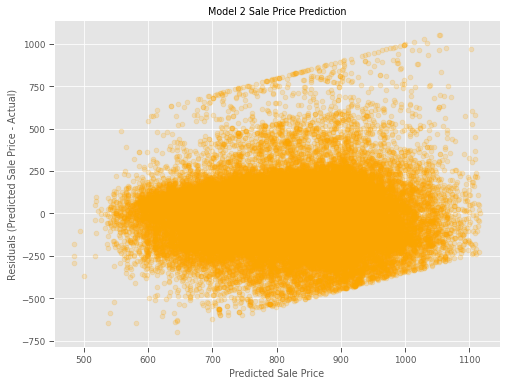

In [234]:
fig5, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title("Model 2 Sale Price Prediction")
ax1.set(xlabel="Predicted Sale Price", ylabel="Residuals (Predicted Sale Price - Actual)")
ax1.scatter(x=y_hat2, y=y_hat2-y2, color='orange', alpha=0.2);

In [194]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y2-y_hat2, ssm_df[['SalePrice']])

print("Lagrange Multiplier p-value:", lm_p_value)
print("F-Statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-Statistic p-value: 0.0


The null hypothesis is that the data is homoscadatic. Based on the graphical representation and het_breuschpagan test, we have sufficient evidence to reject the null hypothesis. While outliers were removed, it appears to be both an underestimation and over estimation for SalePrice. Further investigation is needed for this dependent variable.

##### Independence

This can be tested using the variance inflation factor from Statsmodels.

In [195]:
rows = ssm_df[["SqFtTotLiving", "TotBathrooms"]].values

In [196]:
vif_df['VIF'] = [variance_inflation_factor(rows, i) for i in range(2)]

In [197]:
vif_df['Feature'] = ["SqFtTotLiving", "TotBathrooms"]

In [198]:
vif_df

,VIF,feature,Feature
0,89.491651,SqFtTotLiving,SqFtTotLiving
1,89.491651,TotBathrooms,TotBathrooms


A VIF score of 5 is too high. So it is reasonable to say that we are violating the independence assumption.

### Model 3 - Adding a Categorical Variables

In [199]:
tsm_df = df[["SalePrice", "SqFtTotLiving", "TotBathrooms", "ViewUtilization" ]].copy()
tsm_df.dropna(inplace=True)

In [200]:
cat_features =['LakeWashington','MtRainier','Olympics', 'Cascades', 'Territorial',
               'SeattleSkyline','PugetSound', 'LakeSammamish','SmallLakeRiverCreek',
               'OtherView','HeatSource', 'Township', 'BldgGrade','FinBasementGrade', 
               'HeatSystem', 'ViewUtilization']

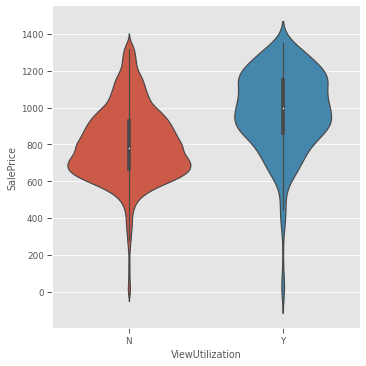

In [236]:
sns.catplot(x='ViewUtilization', y='SalePrice', data=df, kind="violin");

ViewUtilization has a binary, wide distribution and would be interesting to investigate with our model.

In [202]:
lbe = LabelEncoder()
VwUtil_labels = lbe.fit_transform(tsm_df["ViewUtilization"]) 

In [203]:
tsm_df['ViewUtilization_Encoded'] = VwUtil_labels
tsm_df.drop('ViewUtilization', axis=1, inplace=True)

In [204]:
tsm = ols(formula="SalePrice ~ SqFtTotLiving + TotBathrooms + ViewUtilization_Encoded",
          data = tsm_df)
tsm_results = tsm.fit()

In [205]:
tsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2611.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:48:13   Log-Likelihood:            -1.7119e+05
No. Observations:               25942   AIC:                         3.424e+05
Df Residuals:                   25938   BIC:                         3.424e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 131.1467     12.167     10.779      0.000     107.299     154.994
SqFtTotLiving              13.2565      0.207     63.957      0.000      12.850      13.663
TotBathrooms                0.9798      9.985      0.098      0.922     -18.592      20.552
ViewUtilization_Encoded   142.1110      6.907     20.576      0.000     128.574     155.648
==============================================================================
Omnibus:                     1707.380   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5348.604
Skew:                          -0.318   Prob(JB):                         0.00
Kurtosis:                       5.131   Cond. No.                         685.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model 3 Evaluation

R2 and Adj R2 are both .245 so only about 25% of the variability in SalePrice (dependent variable) can be  explained by the independent variables in this model.

The Prob(F-statistic) which estimates the likelylood that this model resulting the way it does is 0.

##### Linearity

In [206]:
rainbow_statistic, rainbow_p_value = linear_rainbow(tsm_results)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:",rainbow_p_value)

Rainbow statistic: 1.0422971757078636
Rainbow p-value: 0.009168122549769371


I used the linear_rainbox(model_results) from Stats models. Its null-hypothesis is that the model shows linearity. The alternate hypothesis is that it does not. The p-value is low meaning that we have sufficient evidence to reject the null-hypothesis. The model violates the assumption of linearity. I must note, that this result is higher that than of model 2.

##### Normality

For this I used the Jarque-Bera test and Jarque-Bera (JB) pvalue. The null hypothesis is that the residuals are normally distributed.  The alternative is that they are not. The p-value is 0 meaning that normality is violated. 

##### Homoscadasticity

This can be visualized using the predicted SalePrice vs the residuals.

In [207]:
y3 = tsm_df['SalePrice']
y_hat3 = tsm_results.predict()

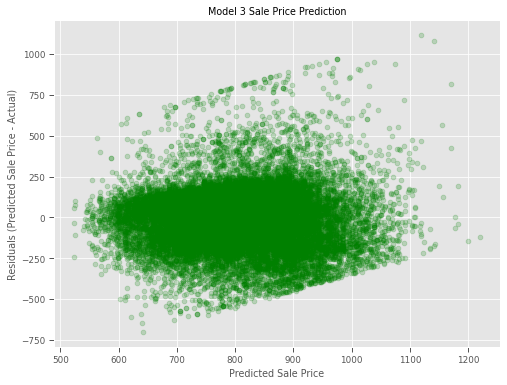

In [237]:
fig8, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title("Model 3 Sale Price Prediction")
ax1.set(xlabel="Predicted Sale Price",
        ylabel="Residuals (Predicted Sale Price - Actual)")
ax1.scatter(x=y_hat3, y=y_hat3-y3, color='green', alpha=0.2);

In [209]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y3-y_hat3, tsm_df[['SalePrice']])

print("Lagrange Multiplier p-value:", lm_p_value)
print("F-Statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-Statistic p-value: 0.0


Based on the graphical representation and het_breuschpagan test, we have sufficient evidence to reject the null hypothesis. There appears to be both an underestimation and over estimation for SalePrice. 

## Summary

We started with a baseline model where the only input feature was `SqFtTotLiving`.  Our baseline model had an r-squared of 0.152.  This model violated the linearity (p < 0.001), normality (p < 0.001), and homoscadasticity (p < 0.001) assumptions of linear regression.  The independence assumption was met by default because there was only one input feature.

The second model used `TotBathrooms` as the other input feature.  Our baseline model had an r-squared of 0.226.  This model violated the linearity (p < 0.001), normality (p < 0.001), and homoscadasticity (p < 0.001) assumptions of linear regression.  The independence assumption was not met.

The final model added a categorical feature `ViewUtilization`.  It had an r-squared of 0.245.  This model violated the linearity (p < 0.001), normality (p < 0.001), and homoscadasticity (p < 0.001) assumptions of linear regression.  The independence assumption was not met.

We are able to address the following:
- Homes that utilized their view tended to have a higher sale price.
- Homes with more bedrooms and total living space tended to have a higher sale price.